# Transformer

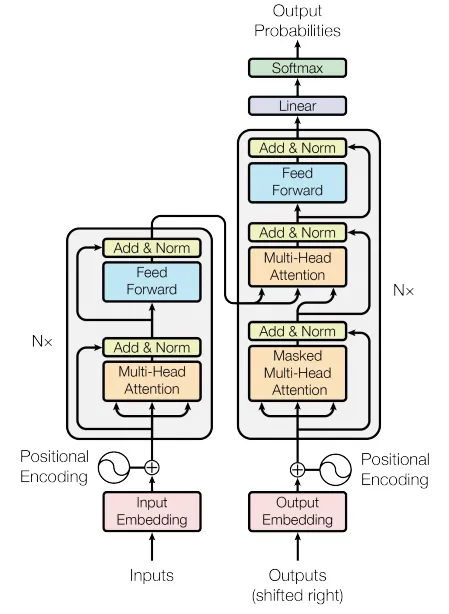

In [2]:
from math import sqrt

import einops
from einops.layers.torch import Reduce
import torch
import torch.nn as nn


## Positional Encoding + Input Embedding


In [6]:
class LinearEmbedding(nn.Sequential):

    def __init__(self, input_channels, output_channels) -> None:
        super().__init__(*[
            nn.Linear(input_channels, output_channels),
            nn.LayerNorm(output_channels),
            nn.GELU()
        ])
        # 創建一個可學習的類別標記(class token),並將其定義為模型的參數
        self.cls_token = nn.Parameter(torch.randn(1, output_channels))

    def forward(self, x):
        # 直接使用上面創建的 Linear -> LayerNorm -> GELU()
        embedded = super().forward(x)
        return torch.cat([einops.repeat(self.cls_token, "n e -> b n e", b=x.shape[0]), embedded], dim=1)


`cls_token = nn.Parameter(torch.randn(1, output_channels))`

這行程式碼的意思是創建一個可學習的類別標記(class token),並將其定義為模型的參數。讓我們分解這行程式碼:

- `torch.randn(1, output_channels)` 創建了一個形狀為 (1, output_channels) 的隨機張量。
    - `1` 表示這個張量只有一個元素,即類別標記。
    - `output_channels` 表示類別標記的維度,與嵌入的維度相同。
    - `torch.randn` 函數從標準常態分佈中隨機取樣值來初始化張量。
- `nn.Parameter(...)` 將這個隨機初始化的張量封裝為一個可學習的參數。
    - 通過將張量傳遞給 `nn.Parameter`,我們告訴 PyTorch 這個張量是模型的一部分,需要在訓練過程中進行優化和更新。
    - 在這種情況下,類別標記 `cls_token` 將作為模型的一個參數,在反向傳播期間根據梯度進行更新。
`cls_token = ...` 將這個可學習的參數賦值給 `cls_token` 變數,以便在模型的前向傳播中使用。

舉個例子,假設 output_channels 的值為 20,那麼 cls_token 將是一個形狀為 (1, 20) 的張量,表示一個 20 維的類別標記。在訓練過程中,這個類別標記將與嵌入的序列一起傳遞給模型,並與序列的其他部分一起進行優化。


`torch.cat([einops.repeat(self.cls_token, "n e -> b n e", b=x.shape[0]), embedded], dim=1)`

這行程式碼的目的是將類別標記 (`cls_token`) 重複 `x.shape[0]` 次,並將其與嵌入的序列 (`embedded`) 在第二個維度 (dim=1) 上進行串聯。

1. `einops.repeat(self.cls_token, "n e -> b n e", b=x.shape[0])`:
    
    - `self.cls_token` 是形狀為 `(1, output_channels)` 的類別標記張量。
        
    - `einops.repeat` 是一個函數,用於重塑和重複張量。它使用一種特殊的表示法來指定輸入和輸出的維度。
        
    - `"n e -> b n e"` 是重塑的表示法,其中:
        
        - `n` 表示類別標記的數量,這裡是 1。
            
        - `e` 表示類別標記的維度,即 `output_channels`。
            
        - `b` 表示批次大小,即 `x.shape[0]`。
            
    - `b=x.shape[0]` 指定了重複的次數,即批次大小。
        
    - 這行程式碼的作用是將類別標記 `cls_token` 重複 `x.shape[0]` 次,使其與批次中的每個樣本相對應。
        
2. `torch.cat([einops.repeat(...), embedded], dim=1)`:
    
    - `torch.cat` 是一個函數,用於在指定維度上串聯張量。
        
    - 這裡,我們將重複後的類別標記張量 `einops.repeat(...)` 和嵌入的序列張量 `embedded` 在第二個維度 (dim=1) 上進行串聯。
        
    - 串聯後的結果將是一個新的張量,形狀為 `(batch_size, sequence_length + 1, output_channels)`,其中第二維的長度增加了 1,**因為我們在序列的開頭添加了類別標記**。


In [14]:
input_channels = 1
output_channels = 192
batch_size = 32
sequence_length = 5

x = torch.randn(batch_size, sequence_length, input_channels)

In [15]:
# 第一維 4 表示批次大小。
# 第二維 6 表示串聯後的序列長度,其中包括 5 個原始序列元素和 1 個添加的類別標記。
# 第三維 20 表示嵌入的維度。
embedding = LinearEmbedding(input_channels, output_channels)
output = embedding(x)
print(f"LinearEmbedding:{embedding}")
print(f"output.shape: {output.shape}")

LinearEmbedding:LinearEmbedding(
  (0): Linear(in_features=1, out_features=192, bias=True)
  (1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (2): GELU(approximate='none')
)
output.shape: torch.Size([32, 6, 192])


## Residual connection

In [3]:
class ResidualAdd(torch.nn.Module):
    def __init__(self, block):
        super().__init__()
        self.block = block

    def forward(self, x):
        return x + self.block(x)

In [5]:
import torch

# 定義一個簡單的神經網絡模塊，將輸入乘以2
class DoubleBlock(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * 2

# 使用ResidualAdd類來創建一個帶殘差連接的模塊
residual_block = ResidualAdd(DoubleBlock())

# 創建一個輸入張量
input_tensor = torch.tensor([1, 2, 3], dtype=torch.int8)

# 通過殘差模塊傳遞輸入
output = residual_block(input_tensor)

# 輸入 [1,2,3] 經過 DoubleBlock 得到 [2,4,6]，再加上輸入得到 [3,6,9]
# 此例子充分展示 Residual add 的功能，通過 x + self.block(x) 進行殘差連接
# x 是原本的輸入 tensor，self.block(x) 是經過模塊處理後的輸出
print(output)

tensor([3, 6, 9], dtype=torch.int8)


## nn.Dropout 

In [20]:
p = 0.5
# Each forward pass will zero out some of the elements of the input tensor
# with probability p. And it will scale the remaining elements by 1/(1-p).
module = nn.Dropout(p=p)
module.training
inp = torch.ones(3,5)
print(f'scale: {1/(1-p)}')
print(f'before dropout:\n{inp}')
print(f'after droput:\n{module(inp)}')
# module(inp)

scale: 2.0
before dropout:
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
after droput:
tensor([[0., 2., 2., 2., 0.],
        [0., 2., 0., 0., 2.],
        [0., 0., 2., 2., 0.]])


## Multi-Head-Attention

這段代碼定義了一個名為 MultiHeadAttention 的 PyTorch 模組類別,用於實現多頭注意力機制。讓我們逐步解釋這段代碼:

1. `__init__` 方法初始化了模組的參數,包括三個線性投影層 (queries_projection, values_projection, keys_projection) 用於將輸入張量投影到 queries、keys 和 values 的空間中。另一個線性投影層 final_projection 用於最終的輸出。此外,還設置了 embed_size 和 num_heads 參數。
2. `forward` 方法定義了模組的前向傳播行為。它首先檢查輸入張量 x 的維度是否為 3 (批次大小、序列長度、嵌入維度)。
接下來,輸入張量 x 被投影到 keys、values 和 queries 的空間中。
3. 使用 `einops` 庫,keys、values 和 queries 被重新排列為多頭表示,其中每個頭對應一個特定的子空間。
4. 計算 `queries` 和 keys 之間的點積,得到 energy_term。
5. `energy_term` 被縮放以防止極端的 softmax 值,然後經過 softmax 運算得到 mh_out。
6. 使用 `torch.einsum` 計算加權和,將 mh_out 與 values 相乘並求和,得到每個頭的輸出。
7. 所有頭的輸出被連接起來,然後通過 `final_projection` 層得到最終的輸出張量。

總的來說,這個模組實現了標準的多頭注意力機制,將輸入序列映射到一組注意力加權的表示,捕獲了不同子空間中的重要信息。這種注意力機制被廣泛應用於諸如 Transformer 等自然語言處理模型中。



In [1]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, embed_size, num_heads, attention_store=None):
        super().__init__()
        self.queries_projection = nn.Linear(embed_size, embed_size)
        self.values_projection = nn.Linear(embed_size, embed_size)
        self.keys_projection = nn.Linear(embed_size, embed_size)
        self.final_projection = nn.Linear(embed_size, embed_size)
        self.embed_size = embed_size
        self.num_heads = num_heads

    def forward(self, x):
        assert len(x.shape) == 3
        keys = self.keys_projection(x)
        values = self.values_projection(x)
        queries = self.queries_projection(x)
        keys = einops.rearrange(keys, "b n (h e) -> b n h e", h=self.num_heads)
        queries = einops.rearrange(queries, "b n (h e) -> b n h e", h=self.num_heads)
        values = einops.rearrange(values, "b n (h e) -> b n h e", h=self.num_heads)
        energy_term = torch.einsum("bqhe, bkhe -> bqhk", queries, keys)
        divider = sqrt(self.embed_size)
        mh_out = torch.softmax(energy_term, -1)
        out = torch.einsum('bihv, bvhd -> bihd ', mh_out / divider, values)
        out = einops.rearrange(out, "b n h e -> b n (h e)")
        return self.final_projection(out)

NameError: name 'torch' is not defined